# 07. Variational Autoencoders (VAE)

<div style="margin:.3rem 0 1rem;font-size:.9em;color:#555;display:flex;align-items:center;gap:.35rem;font-family:monospace">
  <time datetime="2025-11-25">25 Nov 2025</time> ·
  <!-- <time datetime="2026-01-18">18 Jan 2026</time> · -->
  <!-- <time datetime="PT9M">9 min</time> -->
</div>

<a href="https://colab.research.google.com/github/shahaliyev/csci4701/blob/main/docs/notebooks/07_vae.ipynb"
   target="_blank" rel="noopener">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open in Colab"
  />
</a>

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    The notebook is currently under revision.
  </p>
</div>

> But the latent process of which we speak, is far from being obvious to men’s minds, beset as they now are. For we mean not the measures, symptoms, or degrees of any process which can be exhibited in the bodies themselves, but simply a continued process, which, for the most part, escapes the observation of the senses. ~ Francis Bacon (Novum Organum)

https://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/readings/L07%20Probabilistic%20Models.pdf

## Decoder Network

Let's say our [latent variable](https://en.wikipedia.org/wiki/Latent_and_observable_variables) $z$ is sampled from a multivariate [Gaussian distribution](https://www.acsu.buffalo.edu/~adamcunn/probability/normal.html): $z \sim \mathcal{N}(\mu,\; \mathrm{diag}(\sigma^2))$. For example, drawing each variable from a normal distribution $\mathcal{N}(0, 1)$ may look like: $
z = [-1.2,\; 0.4,\; 2.1,\; -0.7,\; \dots].$

We can pass an $L$-dimensional input $z$ to our neural network (decoder) with parameters $\theta$. The decoder should produce a conditional distribution $p_\theta(x \mid z)$, which tells how likely an output $x$ is for a given latent $z$. By adjusting $\theta$, we want this conditional distribution to produce samples whose overall distribution approximates the true data distribution $p^\ast(x)$. In other words, when $z$ is drawn from some latent distribution, the resulting samples $x \sim p_\theta(x \mid z)$ should resemble real observable data. The true distribution $p^\ast(x)$ is some unknown underlying distribution of universe the data lives in.

Let's consider [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, where each data point is a `28x28` grayscale image. The decoder, then, should generate `784` probabilities (one for each pixel):

$$
p_\theta(x = 1 \mid z) = (p_1, p_2, \dots, p_{784}).
$$

Here, each $p_j \in [0,1]$ is the model's predicted probability that pixel $j$ is "on". With these probabilities, the conditional [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) of the image $x$ given the latent variable $z$, also denoted by $p_\theta(x \mid z)$ (now a scalar) is:

$$
p_\theta(x \mid z) = \prod_{j=1}^{784} \text{Bernoulli}(x_j \mid p_j),
$$

where $x_j$ is the observed pixel value in the data. This expression defines a [Bernoulli distribution](https://www.acsu.buffalo.edu/~adamcunn/probability/bernoulli.html) for each pixel, and the full likelihood is the product over all pixels, assuming independence. It tells us how likely a particular image $x$ is, given a latent vector $z$.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, out_dim=784):
    super().__init__()
    self.fc1 = nn.Linear(latent_dim, 512)
    self.fc2 = nn.Linear(512, out_dim)

  def forward(self, z):
    z = z.view(z.size(0), -1)
    logits = self.fc2(F.relu(self.fc1(z)))
    return F.sigmoid(logits)

In [ ]:
LATENT_DIM = 20
BATCH_SIZE = 32

As mentioned above, we need to sample $z$ from a multivariate Gaussian distribution, where $\mu \in [-\infty, \infty]$ and $\sigma^2 \geq 0$. We will use `torch.randn()` function to simulate random generation. Exponential function `torch.exp()` will be needed for mapping infinite range to be non-negative for variance.

In [ ]:
mean    = torch.randn(BATCH_SIZE, LATENT_DIM)
logvar  = torch.randn(BATCH_SIZE, LATENT_DIM)
var     = torch.exp(logvar) # var >= 0

In practice, we will learn suitable values for mean and variance. We can now sample $z \sim \mathcal{N}(\mu,\; \mathrm{diag}(\sigma^2))$, noting that `torch.normal()` function accepts $\sigma$ instead of $\sigma^2$.

In [ ]:
z = torch.normal(mean, torch.sqrt(var))
dec = Decoder(LATENT_DIM)
p_x_given_z = dec.forward(z)

Plotting the generated distribution $p_\theta(x \mid z)$ above will naturally produce noise, as the decoder parameters are random. We need to figure out a way to train our network for optimal parameters.

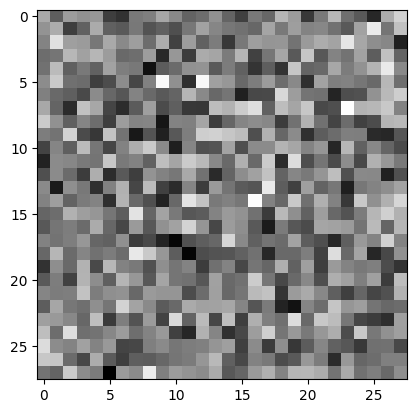

In [ ]:
plt.imshow(p_x_given_z[0].detach().numpy().reshape(28,28), cmap='gray');

## Intractable Integral

As we have already introduced the latent variable $z$ to our probabilistic model, we can suggest that our objective is to learn the joint distribution $p(x, z)$, which has a well-known formula:

$$
p_\theta(x, z) = p_\theta(x \mid z)\, p(z).
$$

Both terms on the right are tractable. The decoder will produce the conditional likelihood $p_\theta(x \mid z)$ via a forward pass. The _prior_ $p(z)$ we can choose to be a simple Gaussian, which has a closed-form density function we can easily compute. The difficulty appears only when we try to compute the _marginal likelihood (evidence)_ of an observed image $x$, which is our approximation of $p^\ast(x)$, given by another well-known formula:

$$
p_\theta(x) = \int p_\theta(x, z)\, dz.
$$

Suppose a simple example of a 1-dimensional latent variable, where $z \in \mathbb{R}$ is a single real number. Even in this 1D case, computing the integral exactly requires evaluating the network $p_\theta(x \mid z)$ at every possible real value of $z$ from $ -\infty$ to $ +\infty$. Even if each dimension were sampled at only $100$ points, this would require $100^{20}$ evaluations for a 20-dimensional latent, which is a number larger than the number of atoms in the universe.

Hence, for a continuous high-dimensional latent vector, evaluating the integral above is computationally impossible due to integral not having a closed-form solution. Integration requires evaluating the decoder network at every point in an $L$-dimensional space which is intractable.

If we could somehow calculate this integral exactly, training the model would be straightforward. For each data point, we would compute log-likelihood $\log p_\theta(x)$ and optimize it with respect to $\theta$ using ordinary gradient descent. Alas, the integral is intractable.


## Encoder Network

Let's introduce the _posterior_ distribution $p_\theta(z \mid x)$ to our probabilistic model. This distribution tells us how likely each latent vector
$z$ is after we observe a particular data point $x$. We can define the posterior through Bayes' rule:

$$
p_\theta(z \mid x) = \frac{p_\theta(x \mid z)\, p(z)}{p_\theta(x)} = \frac{p_\theta(x, z)}{\int p_\theta(x, z)\, dz}.
$$

However, the posterior is also _intractable_, as the denominator is intractable. How to tackle this problem? Authors of the Variational Autoencoder (VAE) paper introduce the _encoder (recognition) model_ which aims at optimizing variational parameters $\phi$ such that the generated posterior $q_\phi(z \mid x)$ is as close as possible to the intractable true posterior $p_\theta(z \mid x)$.

In simple terms, the encoder is a neural network with learnable parameters $\phi$ that outputs an approximate mean and variance of the required Gaussian distribution for each input $x$. Instead of sampling $z$ randomly out of blue, we will sample our latent variable from the learned distribution $q_\phi(z \mid x)$ which is dependent on the input data.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dim, out_dim=128):
    super().__init__()
    self.conv1   = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
    self.conv2   = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
    self.fc1     = nn.Linear(32 * 5 * 5, out_dim)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.mean    = nn.Linear(out_dim, latent_dim)
    self.logvar  = nn.Linear(out_dim, latent_dim)

  def forward(self, x):
    out1 = self.maxpool(F.relu(self.conv1(x)))
    out2 = self.maxpool(F.relu(self.conv2(out1)))
    out2 = out2.view(out2.size(0), -1)
    out3 = F.relu(self.fc1(out2))
    mean = self.mean(out3)
    logvar = self.logvar(out3)
    return mean, logvar

Once we have our encoder, we can sample the latent variable $z$ conditioned on the input data. We will now load the MNIST dataset and demonstrate the process for a single batch of data.

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2
BATCH_SIZE = 64
LATENT_DIM = 30

In [ ]:
train_data   = torchvision.datasets.MNIST('root',train=True,transform=transforms.ToTensor(),download=True)
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

100%|██████████| 9.91M/9.91M [00:00<00:00, 23.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 614kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


In [ ]:
enc = Encoder(LATENT_DIM).to(DEVICE)
dec = Decoder(LATENT_DIM).to(DEVICE)

In [ ]:
imgs, _ = next(iter(train_loader))
imgs = imgs.to(DEVICE)

mean, logvar = enc.forward(imgs)
var = torch.exp(logvar)

q_z_given_x = torch.normal(mean, torch.sqrt(var))
p_x_given_z = dec.forward(q_z_given_x)

Note that the MNIST pixel intensities are continuous values in $[0,1]$, not binary values $0$ and $1$. We can still use a Bernoulli likelihood for each pixel because the Bernoulli log-likelihood is exactly the same expression used in binary [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy). Thus,

$$
p_\theta(x \mid z) = \prod_{j=1}^{784} p_j^{\,x_j} (1 - p_j)^{\,1 - x_j},
$$

and

$$
\log p_\theta(x \mid z) = \sum_{j=1}^{784} x_j \log p_j + (1 - x_j) \log (1 - p_j)
$$

remain valid even when the observed pixel values $x_j$ are real numbers in
$[0,1]$. Treating $x_j$ as a fractional target simply corresponds to using
binary cross-entropy, which is well-defined for any $x_j \in [0,1]$.

In [ ]:
LL = -F.binary_cross_entropy(imgs.view(imgs.size(0),-1), p_x_given_z, reduction='sum')
print(f'Log-likelihood: {LL.item():.4f}')

Log-likelihood: -2033668.5000


The generated output will naturally again be noise, as neither encoder nor decoder parameters ($\phi$ and $\theta$) are optimal. The goal of VAE is to efficiently learn those parameters and maximize the likelihood.

## Evidence Lower Bound (ELBO)

Recall that we couldn't maximize the marginal likelihood $\log p_\theta(x)$ due to intractability. It turns out, with a nice trick up our sleeves, we can rewrite the marginal likelihood as expectation. The trick is that integrating any probability density over its entire domain is equal to $1$.

$$
p_\theta(x) = p_\theta(x)\int q_\phi(z \mid x)\,dz  = \mathbb{E}_{q_\phi(z \mid x)}[\,p_\theta(x)\,].
$$

Our likelihood function $p_\theta(x)$ above returns a constant for each observed data point which does not depend on $z$. A constant function means that every possible value of the variable, no matter its probability, produces exactly the same output, so the weighted average (expectation) cannot change that value.

Once we rewrite our likelihood as expectation, we can now make use of our variational posterior and Bayes rule to reach the following equation for log-likelihood:

$$
\begin{aligned}
\log p_\theta(x)
&= \mathbb{E}_{q_\phi(z \mid x)}[\, \log p_\theta(x)\,] \\
&= \mathbb{E}_{q_\phi(z \mid x)}\!\left[\, \log
\left[
\frac{p_\theta(x,z)}{p_\theta(z \mid x)}
\right]\right] \\
&= \mathbb{E}_{q_\phi(z \mid x)}\!\left[\,
\log \left[\frac{p_\theta(x,z)}{q_\phi(z \mid x)}
\cdot
\frac{q_\phi(z \mid x)}{p_\theta(z \mid x)}\right]
\right] \\
&= \mathbb{E}_{q_\phi(z \mid x)}\!\left[\log \frac{p_\theta(x,z)}{q_\phi(z \mid x)}\right]
+ \mathbb{E}_{q_\phi(z \mid x)}\!\left[\log \frac{q_\phi(z \mid x)}{p_\theta(z \mid x)}\right].
\end{aligned}
$$


Here, the equation on the right corresponds to the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) formula $\mathrm{KL}\!\left[q_\phi(z \mid x)\,\|\, p_\theta(z \mid x)\right]$ between variational and true posteriors. As KL divergence is positive or zero (in case our encoder somehow generates the true posterior), and $p_\theta(z \mid x)$ is unknown, we can ignore the KL divergence and concentrate on the first equation, which we call [Evidence Lower Bound](https://yunfanj.com/blog/2021/01/11/ELBO.html) (ELBO). We can safely claim that our equation on the left will return a lower-bound of the log-likelihood for observed data:

$$\mathcal{L}_{\theta,\phi}(x) \leq \log p_\theta(x).$$

We can rewrite ELBO equation further:

$$
\begin{aligned}
\mathcal{L}_{\theta,\phi}(x)
&= \mathbb{E}_{q_\phi(z \mid x)}\!\left[\log \frac{p_\theta(x,z)}{q_\phi(z \mid x)}\right] \\
&= \mathbb{E}_{q_\phi(z \mid x)}
\big[\log p_\theta(x,z) - \log q_\phi(z \mid x)\big] \\
&= \mathbb{E}_{q_\phi(z \mid x)}
\big[\log p_\theta(x \mid z) + \log p_\theta(z) - \log q_\phi(z \mid x)\big] \\
&= \mathbb{E}_{q_\phi(z \mid x)}\big[\log p_\theta(x \mid z)\big]
- \mathrm{KL}\!\left(q_\phi(z \mid x)\,\|\, p_\theta(z)\right).
\end{aligned}
$$

It turns out, instead of [maximizing the log-likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of our evidence (a single data point) which is intractable, we can aim at maximizing ELBO, the lower bound of our evidence likelihood, which is fully tractable. We can simply plug in and calculate the solution for the equation above and optimize our network for both $\phi$ and $\theta$ within a single backward pass.

## Unbiased Gradient Estimation

We should now calculate gradients but we have a problem again. A single data point ELBO gradient is intractable as the expected value of the likelihood requires computing integral over all possible latent variables. Luckily, we can find an [unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of the gradient w.r.t. $\theta$ with the help of Monte Carlo sampling.

$$
\begin{aligned}
\nabla_{\theta} \mathcal{L}_{\theta,\phi}(x)
&= \nabla_{\theta}\, \mathbb{E}_{q_{\phi}(z \mid x)}
    \left[ \log p_{\theta}(x, z) - \log q_{\phi}(z \mid x) \right] \\
&= \mathbb{E}_{q_{\phi}(z \mid x)}
    \left[ \nabla_{\theta}\left( \log p_{\theta}(x, z) - \log q_{\phi}(z \mid x) \right) \right] \\
&\simeq \nabla_{\theta}\left( \log p_{\theta}(x, z) - \log q_{\phi}(z \mid x) \right) \\
&= \nabla_{\theta}\log p_{\theta}(x, z).
\end{aligned}
$$

Monte Carlo estimator allows us to draw a few samples from $q_{\phi}(z \mid x)$ and approximate the expectation by averaging the function values at those samples. This works because the average of randomly drawn samples converges to the true expectation as $K$ increases. Using this approximation inside the gradient gives

$$
\nabla_{\theta}\, \mathbb{E}_{q_{\phi}(z \mid x)}[f(z)]
\approx
\frac{1}{K} \sum_{k=1}^{K} \nabla_{\theta} f\!\left(z^{(k)}\right),
\qquad
z^{(k)} \sim q_{\phi}(z \mid x).
$$

which is an unbiased estimate of the true gradient. During neural network training, a single sample already provides an unbiased Monte Carlo estimate, as averaging comes from the minibatch: if a batch contains $B$ data points, the stochastic gradient $\frac{1}{B} \sum_{i=1}^{B} \nabla f\!\left(z^{(1)}_i\right)$ acts as the Monte Carlo average. Hence, we can use $K = 1$ and rely on minibatches to reduce variance.


## Reparametrization Trick

Estimating gradients w.r.t variational parameters $\phi$ is more complicated. The parameter $\phi$ appears inside the distribution $q_{\phi}(z \mid x)$, which means that when we take a gradient of the ELBO, we must also differentiate through the sampling operation itself:

$$
\begin{aligned}
\nabla_{\phi} \mathcal{L}_{\theta,\phi}(x)
&=
\nabla_{\phi}\, \mathbb{E}_{q_{\phi}(z \mid x)}
\left[
\log p_{\theta}(x, z) - \log q_{\phi}(z \mid x)
\right]. \\
&\neq \mathbb{E}_{q_{\phi}(z \mid x)}
\left[\nabla_{\phi}\,
(\log p_{\theta}(x, z) - \log q_{\phi}(z \mid x)
\right)].
\end{aligned}
$$

To obtain a usable gradient estimator, we rewrite the sampling process in a differentiable form. Instead of sampling $z$ directly from $q_{\phi}(z \mid x)$, we introduce a noise variable $\epsilon$ that does not depend on $\phi$:

$$
z = \mu_{\phi}(x) + \sigma_{\phi}(x)\,\epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I).
$$

This is the **reparameterization trick**. Now the randomness comes only from $\epsilon$, while $z$ becomes a deterministic and differentiable function of $\phi$. Using this transformation, the expectation can be rewritten as

$$
\mathbb{E}_{q_{\phi}(z \mid x)}[f(z)]
=
\mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)}
\left[
f\!\left(\mu_{\phi}(x) + \sigma_{\phi}(x)\epsilon\right)
\right],
$$

allowing gradients to pass through $z$ via standard backpropagation. The resulting gradient becomes

$$
\begin{aligned}
\nabla_{\phi} \mathcal{L}_{\theta,\phi}(x)
&=
\mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)}
\left[
\nabla_{\phi}
\left(
\log p_{\theta}(x, z)
-
\log q_{\phi}(z \mid x)
\right)
\right].
\end{aligned}
$$


where $z = \mu_{\phi}(x) + \sigma_{\phi}(x)\, \epsilon$ which provides a low-variance and unbiased estimator that makes VAE optimization possible. As a consequence, a single data point Monte Carlo estimator becomes

$$
\tilde{\mathcal{L}}_{\theta,\phi}(x)
=
\log p_{\theta}(x, z)
-
\log q_{\phi}(z \mid x).
$$

Applying reparametrization trick allows PyTorch smoothly use autograd engine when calculating gradients.

In [ ]:
def reparam(mean, var):
  eps = torch.randn_like(mean)
  std = torch.sqrt(var)
  z = mean + std * eps
  return z

## VAE Training

We now have built all the tools required for coding the training logic of VAE. Almost all the tools. As the derivation is complicated and distractive for the main text, I will note the formula for the closed-form ELBO KL-divergence term in the appendix.

In [ ]:
LR = 0.001
NUM_EPOCHS = 10

In [ ]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=LR)

Decoder(
  (fc1): Linear(in_features=30, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
dec.train()
for e in range(NUM_EPOCHS):
  loss = 0
  for X, _ in train_loader:
    X = X.to(DEVICE)
    optimizer.zero_grad()

    mean, logvar = enc.forward(X)
    var = torch.exp(logvar)

    q_z_given_x = reparam(mean, var)
    p_x_given_z = dec.forward(q_z_given_x)

    LL = -F.binary_cross_entropy(p_x_given_z, X.view(X.size(0), -1), reduction='sum')
    KL = 0.5 * torch.sum(mean**2 + var - 1 - logvar)
    ELBO = LL - KL
    batch_loss = -ELBO

    batch_loss.backward()
    optimizer.step()
    loss += batch_loss.item() / (BATCH_SIZE * 784)
  print(f"Epoch {e+1}/{NUM_EPOCHS}, Loss: {loss:.4f}")

Epoch 1/10, Loss: 121.4904
Epoch 2/10, Loss: 121.4055
Epoch 3/10, Loss: 121.3329
Epoch 4/10, Loss: 121.2401
Epoch 5/10, Loss: 121.1607
Epoch 6/10, Loss: 121.0556
Epoch 7/10, Loss: 121.0213
Epoch 8/10, Loss: 120.9725
Epoch 9/10, Loss: 120.8978
Epoch 10/10, Loss: 120.7906


## VAE Generation

After we train VAE network, all we need to do is sample our $z$ from a Guassian prior and pass it to our decoder for generation. If we have done everything right, we may even see some MNIST-like numbers on the screen.

In [ ]:
dec.eval()

with torch.no_grad():
  z = torch.randn(BATCH_SIZE, LATENT_DIM, device=DEVICE)
  imgs = dec.forward(z)

imgs = imgs.detach().cpu().numpy()

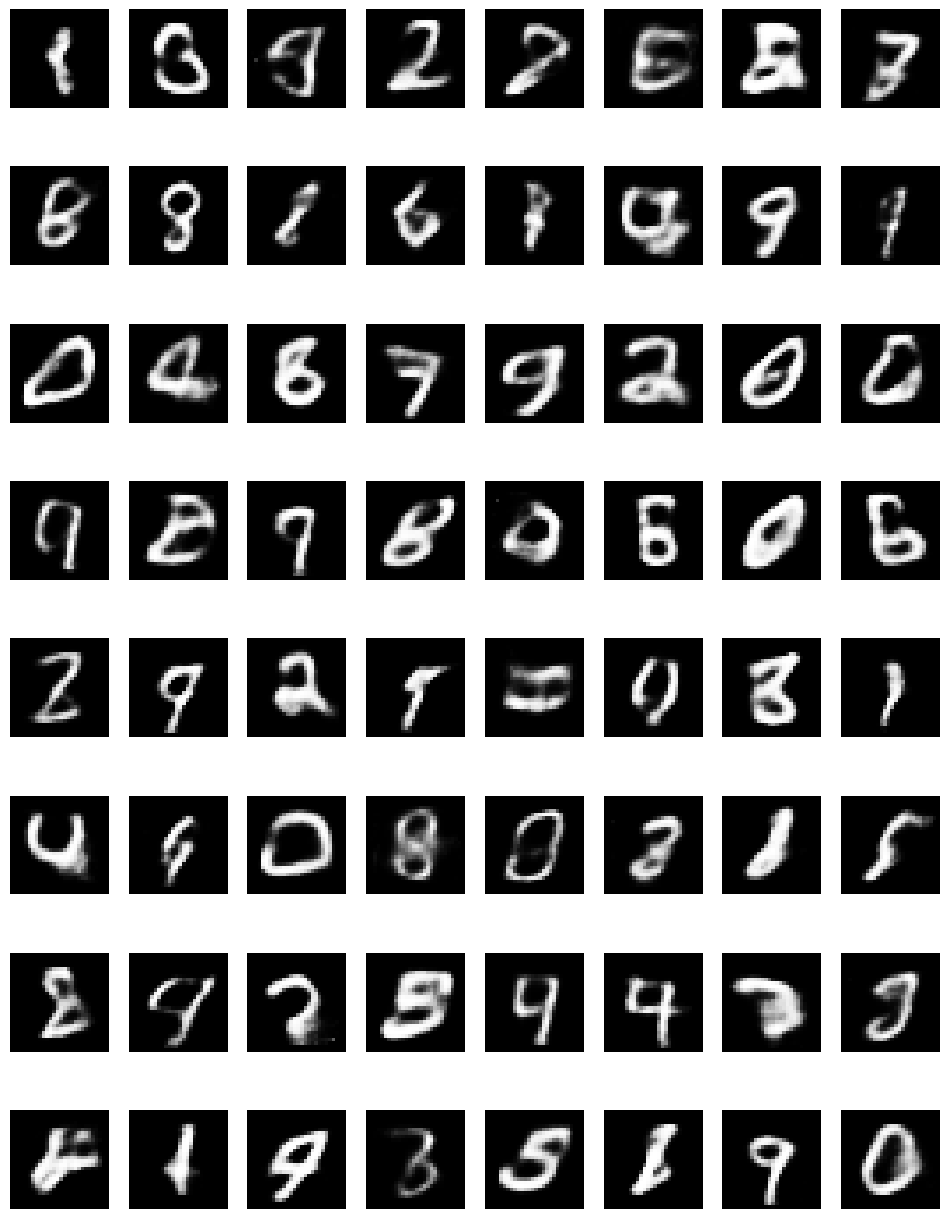

In [ ]:
num_imgs = imgs.shape[0]
imgs_per_row = 8
num_rows = (num_imgs + imgs_per_row - 1) // imgs_per_row

plt.figure(figsize=(12, num_rows * 2))

for i in range(num_imgs):
    plt.subplot(num_rows, imgs_per_row, i + 1)
    plt.imshow(imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

## Closed-Form Gaussian KL-divergence

We already know that $\log p_\theta(x \mid z)$ can be treated as a BCE loss. However, we still need to figure out closed-form solutions for finding the right-hand side of ELBO, which has the following log form:

$$
\mathrm{KL}\!\left(q_\phi(z \mid x)\,\|\,p(z)\right)
=
\mathbb{E}_{q_\phi(z\mid x)}
\Big[
\log q_\phi(z\mid x)
-
\log p(z)
\Big].
$$

Gaussian family is one of the few distributions where the KL-divergence has a simple analytic form. For example, in 1D, approximate posterior distribution $q_\phi(z \mid x)$ and prior could be sampled from $\mathcal{N}(\mu, \sigma^2)$ and $\mathcal{N}(0, 1)$ respectively. Knowing that standard normal is a special case of normal distribution, we have:

\begin{aligned}
\log q_\phi(z \mid x)
&=
\log\!\left[
\frac{1}{\sqrt{2\pi\sigma^{2}}}
\exp\!\left(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\right)
\right] \\
&=
-\frac{1}{2}\log(2\pi\sigma^{2})
-
\frac{(z-\mu)^{2}}{2\sigma^{2}}.
\end{aligned}

Therefore, subtracting Gaussians has the following form:

\begin{aligned}
\log q_\phi(z \mid x) - \log p(z)
&=
\left[
-\frac{1}{2}\log(2\pi\sigma^{2})
-
\frac{(z-\mu)^{2}}{2\sigma^{2}}
\right]
-
\left[
-\frac{1}{2}\log(2\pi)
-
\frac{z^{2}}{2}
\right] \\
&=
-\frac{1}{2}\log\sigma^{2}
-
\frac{(z-\mu)^{2}}{2\sigma^{2}}
+
\frac{z^{2}}{2}.
\end{aligned}

Substituting these moments into the KL expression with its expectation form, we obtain:
$$
\begin{aligned}
\mathbb{E}_{q_\phi(z\mid x)}
\Big[
\log q_\phi(z\mid x)
-
\log p(z)
\Big]
&=
\mathbb{E}_{q_\phi(z \mid x)}
\Big[
-\tfrac{1}{2}\log\sigma^{2}
-
\tfrac{(z-\mu)^{2}}{2\sigma^{2}}
+
\tfrac{z^{2}}{2}
\Big] \\[6pt]
&=
-\tfrac{1}{2}\log\sigma^{2}
-
\tfrac{1}{2\sigma^{2}}
\mathbb{E}_{q_\phi(z \mid x)}[(z-\mu)^{2}]
+
\tfrac{1}{2}
\mathbb{E}_{q_\phi(z \mid x)}[z^{2}].
\end{aligned}
$$

which becomes, after substituting the known Gaussian moments $\sigma^{2}$ and $\mu^{2} + \sigma^{2}$:

$$
\begin{aligned}
\mathrm{KL}\!\left(q_\phi(z \mid x)\,\|\,p(z)\right)
&=
-\tfrac{1}{2}\log\sigma^{2}
-
\tfrac{1}{2}
+
\tfrac{1}{2}\mu^{2}
+
\tfrac{1}{2}\sigma^{2} \\[6pt]
&=
\tfrac{1}{2}
\left(
\mu^{2}
+
\sigma^{2}
-
1
-
\log\sigma^{2}
\right).
\end{aligned}
$$

For $L$-dimensional latent variable, approximate posterior we choose to be a multivariate Gaussian with a diagonal covariance:
$q_\phi(z \mid x)=\mathcal{N}\!\big(\mu, \mathrm{diag}(\sigma^2)\big),$
and the prior a standard multivariate normal:
$p(z) = \mathcal{N}(0, I).$ Because the covariance of $q_\phi(z \mid x)$ is diagonal, both $q_\phi(z \mid x)$ and $p(z)$ factorize over dimensions:
$$
q_\phi(z \mid x)
=
\prod_{j=1}^L q_{\phi,j}(z_j \mid x),
\qquad
p(z)
=
\prod_{j=1}^L p_j(z_j).
$$

From here, we can derive the final closed-form equation for the KL-divergence between approximate posterior and prior:

$$
\begin{aligned}
\mathrm{KL}\!\left(q_\phi(z \mid x)\,\|\,p(z)\right)
&=
\sum_{j=1}^L
\mathrm{KL}\!\left(q_{\phi,j}(z_j \mid x)\,\|\,p_j(z_j)\right) \\
&=
\tfrac{1}{2}
\sum_{j=1}^L
\left(
\mu_j^{2}
+
\sigma_j^{2}
-
1
-
\log\sigma_j^{2}
\right).
\end{aligned}
$$


## CIFAR-10

In [ ]:
train_data = torchvision.datasets.CIFAR10('root',train=True,transform=transforms.ToTensor(),download=True)
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True, batch_size=32, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


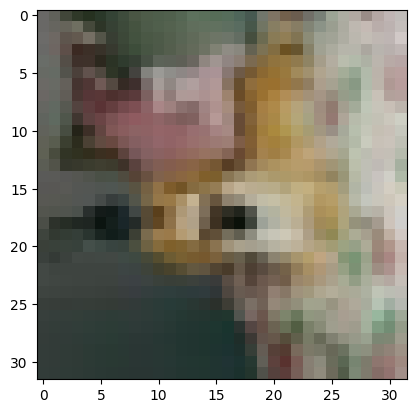

In [ ]:
batch = iter(train_loader)
imgs, labels = next(batch)
plt.imshow(imgs[0].reshape(3, 32, 32).permute(2, 1, 0));

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
    self.fc1 = nn.Linear(32 * 5 * 5, 128)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.mean = nn.Linear(128, 20)
    self.log_sigma = nn.Linear(128, 20)

  def forward(self, x):
    out1 = self.maxpool(F.relu(self.conv1(x)))
    out2 = self.maxpool(F.relu(self.conv2(out1)))
    out2 = out2.view(out2.size(0), -1)
    out3 = self.fc1(out2)
    mean = self.mean(out3)
    log_sigma = self.log_sigma(out3)
    return mean, log_sigma

  def rsample(self, mean, log_sigma):
    eps = torch.randn_like(mean)
    std = torch.exp(0.5 * log_sigma)
    z = mean + std * eps
    return z

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(20, 128)
    self.fc2 = nn.Linear(128, 784)

  def forward(self, x):
    out1 = F.relu(self.fc1(x))
    out2 = torch.sigmoid(self.fc2(out1))
    return out2.view(out2.size(0), 1, 28, 28)

In [ ]:
epochs = 50
for e in range(epochs):
  loss = 0.0
  for img, labels in train_loader:
    img, labels = img.to(device=device), labels.to(device=device)
    optimizer.zero_grad()
    mean, log_sigma = enc.forward(img)
    z = enc.rsample(mean, log_sigma)
    out = dec.forward(z)
    LL = -F.binary_cross_entropy(out, img, reduction='sum')
    sigma = torch.exp(0.5 * log_sigma)
    KL = 0.5 * torch.sum(mean*mean + torch.exp(log_sigma) - log_sigma - 1)
    ELBO = LL - KL
    batch_loss = -ELBO
    batch_loss.backward()
    optimizer.step()
    loss += batch_loss
  print(f'Epoch {e} loss is {loss/len(train_loader)}')